# Single Simulation Example

## Imports and Parameters

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy
from scipy import signal
from scipy.ndimage import map_coordinates
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm

'''Neural Field Model'''
# Random Seed
seed = 42
np.random.seed(seed)

# Number of Nodes (must be odd for fft transform)
''' Increasing Number of nodes (neural populations) increases spatial frequency
however beyond ~250 the forms won't fully develop'''
NN = 115

# Timestep (ms)
dt = 0.2

# Time constant - Rule et al. 2011
Te = 10.0
Ti = 20.0

# Spatial Connectivity Constants - Rule et al. 2011
Se = 2
Si = 2.5 * Se

# Connectivity Constants - Rule et al. 2011
Aee = 10
Aei = 12
Aie = 8.5
Aii = 3.0

# Threshold/Bias (theta) - Rule et al. 2011
He = 2.0
Hi = 3.5

# Gain on stimulation / Input drive - Rule et al. 2011
Ge = 1
Gi = 0

# Noise = Rule et al. 2011
Ne = 0.05
Ni = 0.05


'''Flicker Stimulus'''

# Constant determining proportion of light to dark from Rule et al (2011))
V = 0.8

'''Retinoptic Map Transformation Equation'''

alpha = 20
beta = 1


'''Connectivity Convolution'''

## Radius of plot of interaction kernel
K_radius_E = NN
K_radius_I = NN

'''Plotting Parameters'''

## Time Duration (ms)
TimeDuration = 1200

## Visualization Resolution
contours = 100

## Functions

In [20]:
### Nonlinear Firing Rate

def F(x):
  return 1 / (1 + np.exp(-x))

### Connectivity Functions

## Gaussian Connectivity Function - Rule et al. 2011
def K(x, y, S):
    ''' This function is not exactly the square of the gaussian (exponent should be
    multiplied by 1/2 in real square) but Ermentrout said to use this...
    Rule doesn't know why'''

    norm_factor = 1 / (np.power(S,2) * np.pi)
    exponent = - (np.power(np.abs(x), 2) + np.power(np.abs(y), 2)) / (np.power(S, 2))

    return norm_factor * np.exp(exponent)

## Convolutional Connectivity Matrices
def generate_gaussian_kernel(sigma, size):
    x = np.arange(-(size//2), size//2 + 1, 1)
    y = np.arange(size//2, -(size//2) - 1, -1)
    X, Y = np.meshgrid(x, y)
    kernel = K(X, Y, sigma)

    return kernel

## FFT Convolution
def fft_convolution(U, K):
    # Perform FFT on the kernels
    k_fft = np.fft.fft2(np.array(K), axes=(0,1))

    # Perform FFT on the inputs
    u_fft = np.fft.fft2(np.array(U), axes=(0,1))

    # Perform element-wise multiplication in Fourier space (frequency domain)
    convolution_u = np.fft.ifft2(u_fft * k_fft, axes=(0,1))

    # Take the real part of the result (to remove any residual imaginary parts due to numerical errors)
    Uc = np.real(convolution_u)

    return Uc


### Stimulus

## Step Function
def H(x):
    return np.maximum(np.sign(x), 0)

## Flicker Stimulus Function
def S(t, A, T):
    return A*H(np.sin((2*np.pi*t)/T)-V)


### Retinoptic Mapping
def retinal_transform(input_img):
    # Get the shape of the input image
    height, width = input_img.shape

    # Create a meshgrid for the output image
    x = np.linspace(-1, 1, width)
    y = np.linspace(-1, 1, height)
    x, y = np.meshgrid(x, y)

    # Convert Cartesian to polar coordinates
    r = np.hypot(x, y)
    theta = (np.arctan2(y, x) + 2 * np.pi) % (2 * np.pi)

    # Scale the output grid coordinates
    r_scaled = np.log(r + 1e-26) / (2 * np.pi)
    theta_scaled = theta / (2 * np.pi)
    
    # Create a new grid for the input image
    x_in = r_scaled * (width)
    y_in = theta_scaled * (height)

    # Map the input image onto the output grid
    transformed_img = map_coordinates(input_img, [y_in, x_in], order=2, mode='grid-wrap')

    return transformed_img



## Simulation

 82%|████████▏ | 4923/6005 [00:03<00:00, 1259.96it/s]

 82%|████████▏ | 4923/6005 [00:03<00:00, 1259.96it/s]

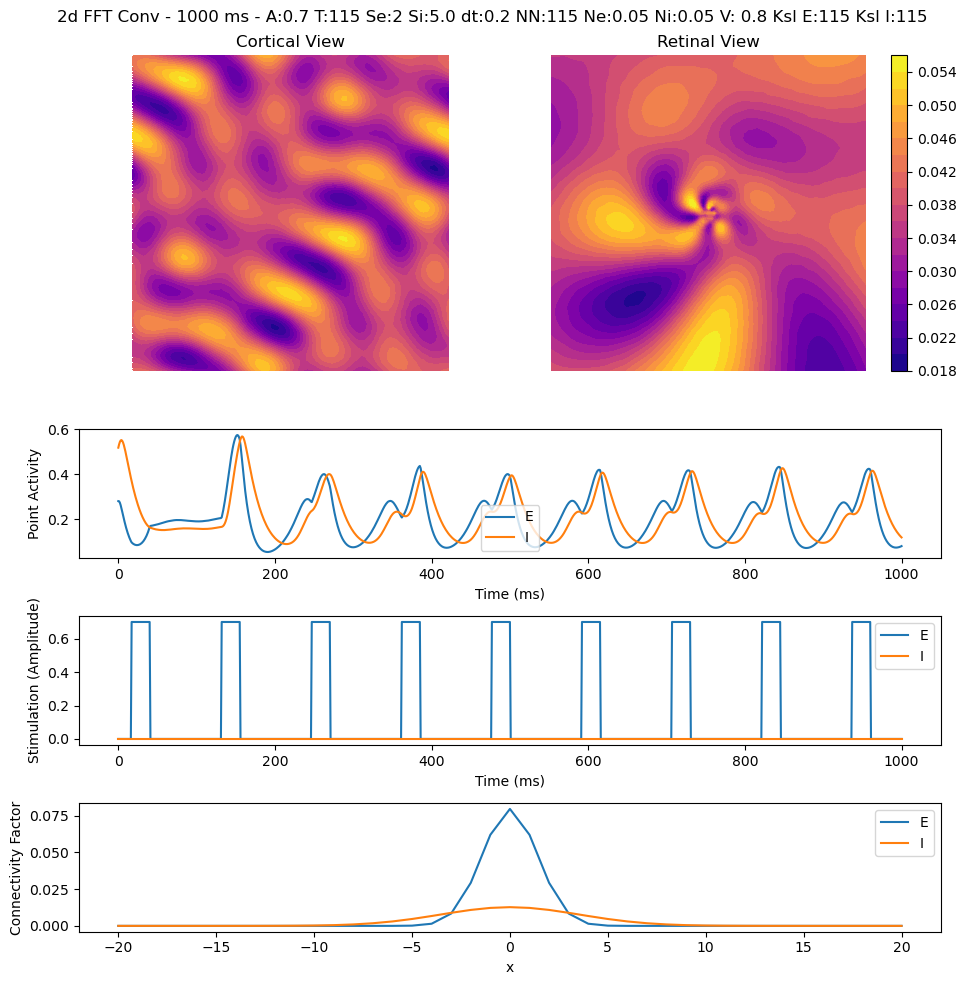

 82%|████████▏ | 4923/6005 [00:03<00:00, 1259.96it/s]

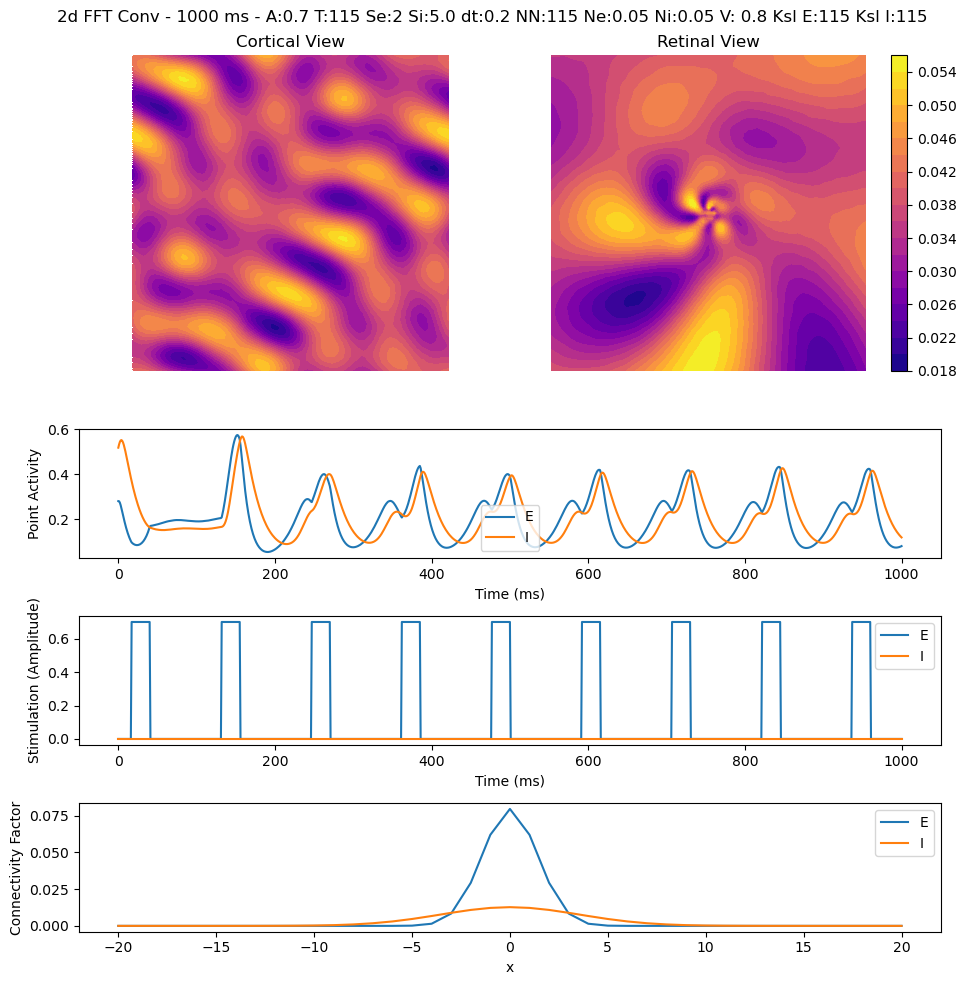

100%|██████████| 6005/6005 [00:04<00:00, 1207.01it/s]


In [ ]:
%matplotlib inline
''' Main Parameters to play with'''

# Amplitude (0.7 produces stable planiforms)
A = 0.7

# Period (50 - 60 Rolls/ 110-130 Spots)
T = 115

''' Plotting Parameters '''

# Plotting Start Time
plot_time_start = 0

# Time interval to record activity (1 - every ms)
plotting_range = range(plot_time_start, TimeDuration + 1, 1)

''' Simulation '''

# Convolutional Connectivity Matrices
K_sidelength_E = NN
K_sidelength_I = NN

Ke = generate_gaussian_kernel(Se, K_sidelength_E)
Ki = generate_gaussian_kernel(Si, K_sidelength_I)

# Initializing Random Activity Rates
Ue = np.random.rand(NN,NN)
Ui = np.random.rand(NN,NN)

# Average Ue/Ui Activity (for plotting)
AvgE = []
AvgI = []

# Activity at a random point (for plotting)
pointE = []
pointI = []

# Time (for plotting)
time = []

# Stimulation (for plotting)
StimE = []
StimI = []

for t in tqdm(range(int((TimeDuration + 1)/dt))):

    # Noise
    Noise = np.random.rand(NN, NN) - 0.5 #center at 0 (range -0.5 to 0.5)

    ## Convolve matrix
    Uec = fft_convolution(Ue, Ke)
    Uic = fft_convolution(Ui, Ki)

    # Euler's Method of Finding Activity Rate of Change
    dUe = (dt/Te)*(-Ue + F(Aee*Uec-Aie*Uic-He+Ge*S(t*dt, A, T)+Ne*Noise))
    dUi = (dt/Ti)*(-Ui + F(Aei*Uec-Aii*Uic-Hi+Gi*S(t*dt, A, T)+Ni*Noise))

    # Updating Neural Field Activities
    Ue += dUe
    Ui += dUi

    if t*dt in plotting_range:

        # Appending Point Activities
        pointE_int = Ue[2,2] # choosing random point at 2,2 to view activity
        pointI_int = Ui[2,2]
        pointE = np.append(pointE, [pointE_int])
        pointI = np.append(pointI, [pointI_int])

        # Appending Time
        time.append(t * dt)

        # Appending Stimulation
        StimE.append(Ge * S(t * dt, A, T))
        StimI.append(Gi * S(t * dt, A, T))

    # Show plot at intervals every 500 ms
    if t*dt != 0 and t*dt % 1000 == 0:

        # Cortical Activity
        cortical_activity = np.abs(Ue - Ui)

        # Retinal Activity
        ret_cortical_activity = retinal_transform(cortical_activity)

        # Plotting
        fig = plt.figure(tight_layout=True, figsize=(10,10))
        gs = gridspec.GridSpec(5, 2)

        ax1 = fig.add_subplot(gs[2, :])
        ax2 = fig.add_subplot(gs[:2, 0])
        ax3 = fig.add_subplot(gs[:2, 1])
        ax4 = fig.add_subplot(gs[3, :])
        ax5 = fig.add_subplot(gs[4, :])

        pointE_plot, = ax1.plot(time, pointE, label='E')
        pointI_plot, = ax1.plot(time, pointI, label='I')
        ax1.set_ylabel('Point Activity')
        ax1.set_xlabel('Time (ms)')
        ax1.legend(handles=[pointE_plot, pointI_plot],loc='lower center')

        cortical_plot = ax2.contourf(cortical_activity, 20, cmap='plasma')
        ax2.set_title('Cortical View')
        ax2.axis('equal')
        ax2.axis('off')

        retinal_plot = ax3.contourf(ret_cortical_activity, 20,
                      cmap='plasma')
        ax3.set_title('Retinal View')
        ax3.axis('equal')
        ax3.axis('off')

        stimE_plot, = ax4.plot(time, StimE, label = 'E')
        stimI_plot, = ax4.plot(time, StimI, label = 'I')
        ax4.set_ylabel('Stimulation (Amplitude)')
        ax4.set_xlabel('Time (ms)')
        ax4.legend(handles=[stimE_plot,stimI_plot])

        x = np.arange(-20, 21, 1)
        K_plotE, = ax5.plot(x, K(x, 0, Se),label='E')
        K_plotI, = ax5.plot(x, K(x, 0, Si), label='I')
        ax5.set_ylabel('Connectivity Factor')
        ax5.set_xlabel('x')
        ax5.legend(handles=[K_plotE,K_plotI])

        divider = make_axes_locatable(ax3)
        cax = divider.append_axes("right", size="5%", pad=0.25)

        fig.colorbar(cortical_plot, cax=cax)

        fig.suptitle("2d FFT Conv - {} ms - ".format(round(t*dt))+
                    "A:{} ".format(round(A,2))+
                    "T:{} ".format(T)+
                    "Se:{} ".format(round(Se,2))+
                    "Si:{} ".format(round(Si,2))+
                    "dt:{} ".format(dt)+
                    "NN:{} ".format(NN)+
                    "Ne:{} ".format(Ne)+
                    "Ni:{} ".format(Ni)+
                    "V: {} ".format(V)+
                    "Ksl E:{} ".format(K_sidelength_E)+
                    "Ksl I:{} ".format(K_sidelength_I))

        plt.show()